In [91]:
from typing import Annotated, List, TypedDict
from langgraph.graph.message import add_messages
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from mcp import ClientSession, StdioServerParameters
from langchain_mcp_adapters.client import MultiServerMCPClient
from openai import OpenAI

load_dotenv()

model_client = OpenAI()

class ChatbotState(TypedDict):
    question: Annotated[str, "Question"]  
    tools: Annotated[List, "Tools"]
    neo4j_documents: Annotated[List, "Neo4j_Documents"]  
    vector_documents : Annotated[List,"Vector_Documents"]
    final_answer: Annotated[str, "Final_Answer"]  
    messages: Annotated[List, add_messages] 

memory = MemorySaver()

client = MultiServerMCPClient(
    {
        "neo4j_retriever": {
            "command": "/opt/anaconda3/envs/boaz/bin/python",
            "args": ["mcp_neo4j_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/opt/anaconda3/envs/boaz/bin/python",
            "args": ["mcp_vectordb_server.py"],
            "transport": "stdio",
        },
    }
)

tools = await client.get_tools()

tools_dict = {tool.name: tool for tool in tools}

print(tools_dict)

{'neo4j_retriever': StructuredTool(name='neo4j_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'neo4j_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x119882840>), 'VectorDB_retriever': StructuredTool(name='VectorDB_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'VectorDB_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x119883d80>)}


In [92]:
tools = [
    {
        "type": "function",
        "name": "neo4j_retriever",
        "description": "Query structured patient-related data, such as surgeries, lab results, or graph-based records.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query about the patient's clinical records"
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    },
    {
        "type": "function",
        "name": "VectorDB_retriever",
        "description": "Retrieve general medical knowledge (diseases, treatments, guidelines).",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query about medical knowledge"
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    }
]

In [93]:
LLM_SYSTEM_PROMPTY = """
# INSTRUCTION
당신은 의료 데이터에 특화된 전문가 AI입니다.
사용자의 질문에 대해 다음 두 가지 출처의 정보를 참고하여 답변을 생성하세요:

1. 🔎 Neo4j 검색 결과: 구조화된 환자 관련 정보 (예: 수술 이력, 검사 기록 등)
2. 📚 VectorDB 검색 결과: 일반적인 의학 지식 (예: 증상 설명, 치료 가이드라인 등)

- 두 결과 모두 존재할 경우, 각 출처를 구분하여 통합적으로 반영하되, 중복 내용은 요약하거나 통합하세요.
- 한 쪽의 결과만 존재할 경우, 해당 결과만을 바탕으로 답변하되, 정보의 한계에 대해 언급하지 말고 최대한 성실히 답변하세요.
- 결과가 너무 적거나 애매하더라도 반드시 유의미한 설명을 제공하려고 노력하세요.
- 불필요한 서론 없이, 질문에 바로 답변하세요.

# Neo4j CONTEXT
{Neo4j}

# Vector DB CONTEXT
{VectorDB}

# Question
{question}
"""

model = ChatOpenAI(temperature=0.2,
                      model_name="gpt-4o")

In [94]:
async def decision_tools(state: ChatbotState):
    
    question = state["question"]

    input_messages = [
        {"role": "system", "content": "Decide which tools to use to answer the user's question. You may call one or both."},
        {"role": "user", "content": question}
    ]
    
    response = model_client.responses.create(model="gpt-4.1",
                                             input=input_messages,
                                             tools=tools)

    selected_tools = [tool.name for tool in response.output]

    return ChatbotState(tools=selected_tools)

async def vector_db(state: ChatbotState):
    question = state["question"]
    
    if "VectorDB_retriever" in state["tools"]:
        vectordb_tool = tools_dict["VectorDB_retriever"]
        
        if vectordb_tool:
            result = await vectordb_tool.ainvoke({"query": question})
        else:
            result = "VectorDB 도구를 찾을 수 없습니다."
    else:
        result = None

    return ChatbotState(vector_documents=result)

async def neo4j_db(state: ChatbotState):
    question = state["question"]
    
    if "neo4j_retriever" in state["tools"]:
        neo4j_tool = tools_dict.get("neo4j_retriever")
        if neo4j_tool:
            result = await neo4j_tool.ainvoke({"query": question})
        else:
            result = "Neo4j 도구를 찾을 수 없습니다."
    else:
        result = None

    return ChatbotState(neo4j_documents=result)

async def merge_outputs(state:ChatbotState):

    question = state['question']
    vector_documents = state['vector_documents']
    neo4j_documents = state['neo4j_documents']

    formatted = LLM_SYSTEM_PROMPTY.format(Neo4j = neo4j_documents,
                                          VectorDB = vector_documents,
                                          question = question)
    response = model.invoke(formatted)
    response_text = response.content if isinstance(response, AIMessage) else str(response)

    return ChatbotState(final_answer=response_text,
                        messages=[("user", question), ("assistant", response_text)])

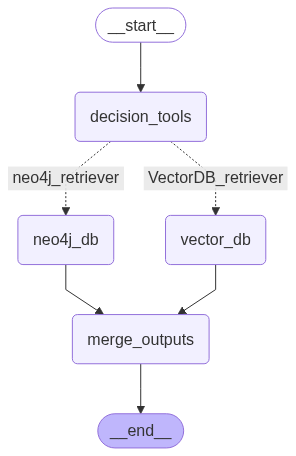

In [95]:
builder = StateGraph(ChatbotState)

builder.add_node("decision_tools", decision_tools)
builder.add_node("vector_db", vector_db)
builder.add_node("neo4j_db", neo4j_db)
builder.add_node("merge_outputs", merge_outputs)

builder.add_edge(START, "decision_tools")

def route_tools(state: ChatbotState):
    return state["tools"]

builder.add_conditional_edges(
    "decision_tools",
    route_tools,
    {
        "neo4j_retriever": "neo4j_db",
        "VectorDB_retriever": "vector_db"
    }
)

builder.add_edge("neo4j_db", "merge_outputs")
builder.add_edge("vector_db", "merge_outputs")
builder.add_edge("merge_outputs", END)

builder.compile(checkpointer=memory)

In [96]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": 1})

question = "Kasabach-Merrritt Syndrome이 뭐야?"

graph = builder.compile(checkpointer=memory)

initial_state = {
    "question": question,
    "tools": [],
    "neo4j_documents": [],
    "vector_documents": [],
    "final_answer": "",
    "messages": [],
}

events = []
async for event in graph.astream(initial_state, config=config):
    print(event)


{'decision_tools': {'tools': ['VectorDB_retriever']}}
{'vector_db': {'vector_documents': 'Kasabach-Merritt syndrome은 거대혈관종, 혈소판감소증, 출혈경향을 동반하는 희귀 질환이다. 혈소판감소증의 주된 원인은 혈관종 내에서 혈소판의 비정상적 소모와 파괴로 생각되고 있으며, 마취와 수술 중 심각한 응고장애로 인한 대량출혈이 발생할 수 있다. 우측 하지 혈관종을 가진 환아는 다양한 내과적 치료에도 반응하지 않는 현저한 혈소판감소증, 파종혈관내응고, 패혈증 소견을 보였고, 좌측 전두엽 국소출혈로 인한 발작까지 발생하여 출혈성 경향을 교정하지 못한 상태에서 무릎밑절단술을 시행하였다\n.].\nKasabach-Merritt syndrome은 거대혈관종, 혈소판감소증, 출혈경향을 동반하고 6개월 이하의 영아에서 주로 발생하는 드문 질환이다. 혈소판감소증의 주된 원인은 혈관종 내에서 혈소판의 비정상적 소모와 파괴로 생각되고 있다. Gilon 등은 말초혈액보다 혈관종 내의 혈액에 혈소판이 더 많다는 것을 발견했고, Hoak 등은 혈관종 안에서 혈전이 형성된다는 것을 확인하였으며, Silver 등은 혈관종 내부의 다발성 모세혈관장애를 치유하기 위해 혈소판이 사용된다고 보고하였다\n. Kasabach-Merritt syndrome은 마취와 수술 중 위험한 상황이 발생할 수 있지만, 국내에서는 이에 대한 보고가 없었다. 저자들은 반복적인 혈소판 수혈에도 혈소판이 현저히 감소된 환아에서 대량출혈을 동반하는 무릎밑절단술의 마취를 경험하였기에 문헌 고찰과 함께 보고하는 바이다. \n체태연령 37주 출생체중 3,100 gm, 질식분만으로 출생한 환자는 출생 당시부터 우측 하지에 부기(swelling) 소견을 보였고 집에서 경과 관찰 중이었다\n. 수술 전 심박수 130회/분, 혈압 85/50 mmHg였고, 활력징후가 수술 중 잘 유지되었기 때문에 승압제는 사용하지 않았다. 수술 후에는 기도출혈, 심